In [2]:
import sys
sys.path.append('..')

import os
project_root = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))

КОНСИСТЕНТНОЕ СРАВНЕНИЕ АГЕНТОВ
Используем ТОЧНУЮ логику MyTradingEnv
Загружаем данные: ../data/data_1h_2024.csv
Данные: 8759 строк, с 42520.73 по 94417.04
Колонки: ['high', 'low', 'close', 'volume', 'date_close']

ТЕСТИРУЕМ: Q-Learning
  Ключи в файле агента: ['name', 'q_table', 'n_actions', 'learning_rate', 'discount_factor', 'epsilon', 'episode_count', 'episode_rewards']
  Размер Q-таблицы: 72
  Распределение лучших действий (по выборке):
    BUY:  26 (36.1%)
    HOLD: 10 (13.9%)
    SELL: 36 (50.0%)
  Пример состояния: [1 2 1 2 0 0] -> (np.int64(1), np.int64(2), np.int64(1), np.int64(2), np.int64(0), np.int64(0))
    Шаг 500, портфель: $1033.55, позиция: 0
    Шаг 1000, портфель: $1054.39, позиция: 0
    Шаг 1500, портфель: $1128.80, позиция: 1
    Шаг 2000, портфель: $1150.66, позиция: 1
    Шаг 2500, портфель: $1206.67, позиция: 0
    Шаг 3000, портфель: $1171.20, позиция: 0
    Шаг 3500, портфель: $1229.59, позиция: 0
    Шаг 4000, портфель: $1190.02, позиция: 0
    Шаг 4500, по

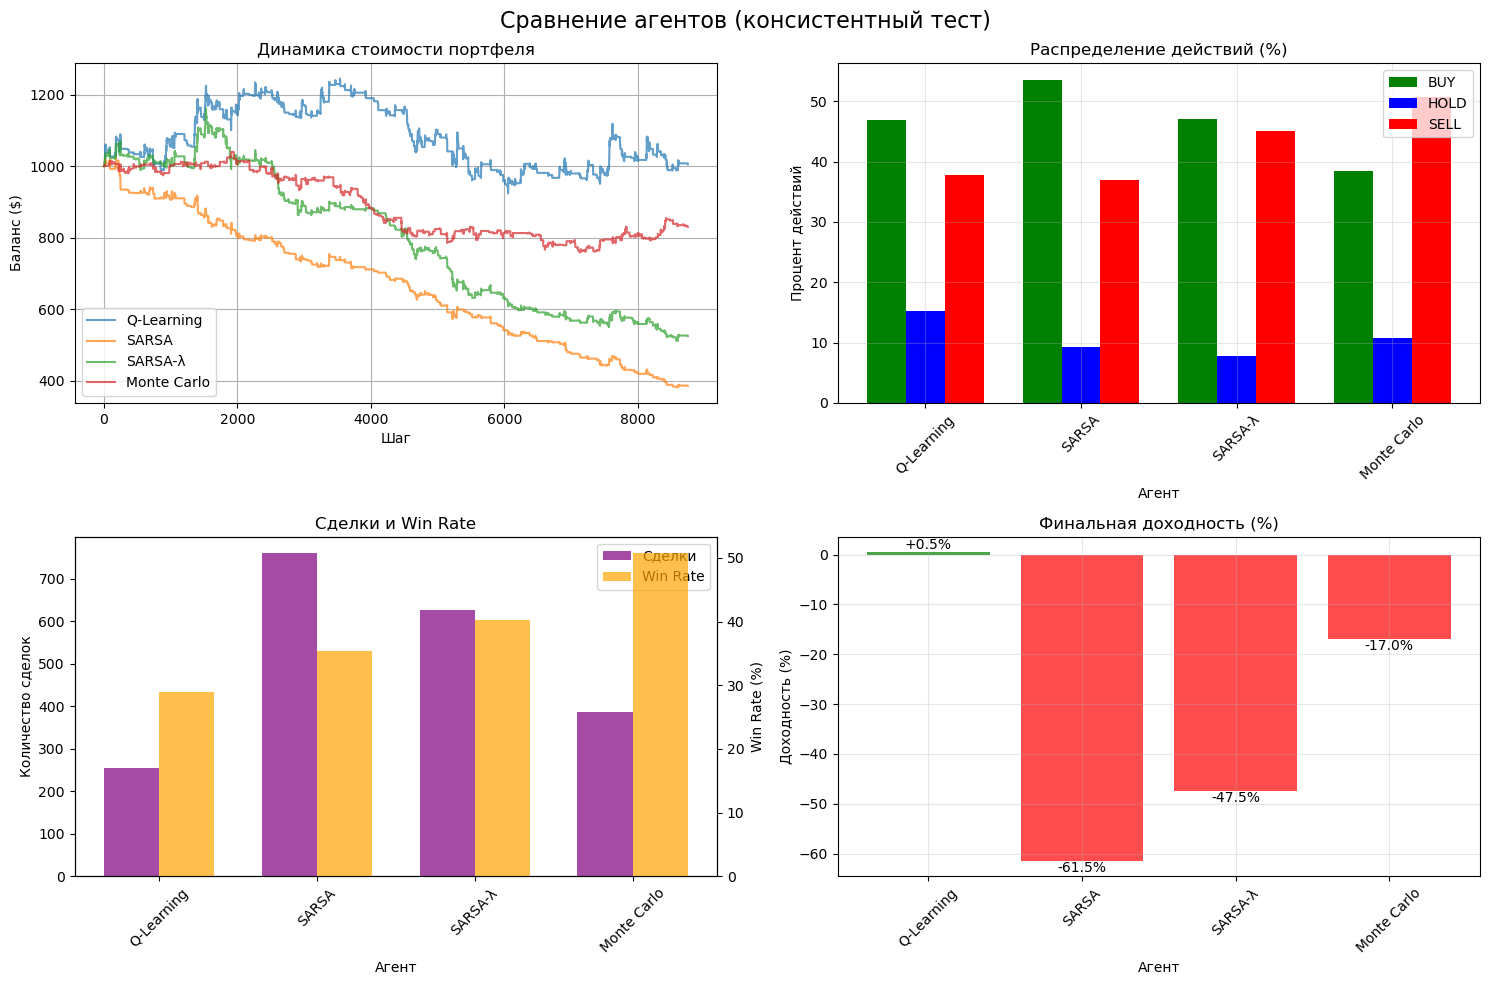

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')
from envs.trading_env import MyTradingEnv

class ConsistentAgentComparator:
    """Сравнение с ТОЧНОЙ логикой окружения MyTradingEnv"""
    
    def discretize_state(self, observation):
        """ТОЧНО такой же метод дискретизации как в MyTradingEnv._get_observation()"""
        # В MyTradingEnv наблюдение уже дискретизировано!
        # observation = [rsi_level, macd_signal, ma_trend, price_trend, position, hold_level]
        return tuple(observation.astype(int))
    
    def run(self):
        print("=" * 70)
        print("КОНСИСТЕНТНОЕ СРАВНЕНИЕ АГЕНТОВ")
        print("Используем ТОЧНУЮ логику MyTradingEnv")
        print("=" * 70)
        
        # Пути к агентам
        agents = {
            "Q-Learning": "../training_data/checkpoints/exp_qlearn_v1/final_agent.pkl",
            "SARSA": "../training_data/checkpoints/exp_sarsa_v1/final_agent.pkl", 
            "SARSA-λ": "../training_data/checkpoints/exp_sarsa_lambda_v1/final_agent.pkl",
            "Monte Carlo": "../training_data/checkpoints/exp_monte_carlo_v1/final_agent.pkl"
        }
        
        # Загрузить данные
        data_path = "../data/data_1h_2024.csv"
        print(f"Загружаем данные: {data_path}")
        
        df_full = pd.read_csv(data_path, index_col=0, parse_dates=True)
        
        # ВАЖНО: используем ту же часть данных что и при обучении
        # По умолчанию при обучении используются все данные
        train_size = int(len(df_full) * 1.0)  # Все данные
        df = df_full.iloc[:train_size].copy()
        
        print(f"Данные: {len(df)} строк, с {df.index[0]} по {df.index[-1]}")
        print(f"Колонки: {df.columns.tolist()}")
        
        results = []
        detailed_results = []
        
        for name, path in agents.items():
            print(f"\n{'='*60}")
            print(f"ТЕСТИРУЕМ: {name}")
            print(f"{'='*60}")
            
            if not Path(path).exists():
                print("❌ Файл не найден")
                continue
            
            try:
                # Загрузить агента
                with open(path, 'rb') as f:
                    agent_data = pickle.load(f)
                
                # Анализируем структуру загруженного агента
                print(f"  Ключи в файле агента: {list(agent_data.keys())}")
                
                # Создаем тестового агента
                class TestAgent:
                    def __init__(self, data, discretize_func):
                        self.q_table = data.get('q_table', {})
                        self.name = data.get('name', 'Unknown')
                        self.discretize = discretize_func
                        self.epsilon = 0.01  # Маленький epsilon для теста
                        
                        if hasattr(self, 'q_table'):
                            print(f"  Размер Q-таблицы: {len(self.q_table)}")
                            
                            # Проанализируем Q-таблицу
                            if len(self.q_table) > 0:
                                # Посчитаем статистику по действиям
                                action_counts = {0: 0, 1: 0, 2: 0}
                                for state_key, q_vals in list(self.q_table.items())[:1000]:
                                    best_action = np.argmax(q_vals)
                                    action_counts[best_action] += 1
                                
                                total = sum(action_counts.values())
                                print(f"  Распределение лучших действий (по выборке):")
                                print(f"    BUY:  {action_counts[0]} ({action_counts[0]/total*100:.1f}%)")
                                print(f"    HOLD: {action_counts[1]} ({action_counts[1]/total*100:.1f}%)")
                                print(f"    SELL: {action_counts[2]} ({action_counts[2]/total*100:.1f}%)")
                    
                    def select_action(self, state, greedy=True):
                        # Дискретизируем состояние
                        state_key = self.discretize(state)
                        
                        # Отладка: покажем первое состояние
                        if not hasattr(self, '_debug_shown'):
                            print(f"  Пример состояния: {state} -> {state_key}")
                            self._debug_shown = True
                        
                        if hasattr(self, 'q_table') and state_key in self.q_table:
                            q_vals = self.q_table[state_key]
                            # Используем epsilon-greedy при обучении
                            if not greedy and np.random.random() < self.epsilon:
                                return np.random.choice([0, 1, 2])
                            return np.argmax(q_vals)
                        
                        # Если состояния нет или нет Q-таблицы
                        return 1  # HOLD по умолчанию
                
                # Создаем агента
                agent = TestAgent(agent_data, self.discretize_state)
                
                # Создаем окружение С ТЕМИ ЖЕ ПАРАМЕТРАМИ что при обучении
                env = MyTradingEnv(
                    df=df.copy(),
                    initial_balance=1000,  # ВАЖНО: такой же как при обучении!
                    window_size=10,
                    commission=0.0001,
                    slippage=0.0005,
                    max_holding_time=60 * 24,
                    max_drawdown_threshold=0.05,
                )
                
                # Запускаем тест
                np.random.seed(42)  # Для воспроизводимости
                state, info = env.reset(seed=42)
                done = False
                step = 0
                actions_count = {0: 0, 1: 0, 2: 0}
                portfolio_values = []
                
                while not done:
                    # При тесте используем greedy (без exploration)
                    action = agent.select_action(state, greedy=True)
                    actions_count[action] += 1
                    
                    next_state, reward, done, truncated, info = env.step(action)
                    state = next_state
                    step += 1
                    
                    portfolio_values.append(env._portfolio_value)
                    
                    if step % 500 == 0:
                        print(f"    Шаг {step}, портфель: ${env._portfolio_value:.2f}, позиция: {env._position}")
                
                # Получаем результаты
                metrics = env.get_metrics()
                
                # Анализируем действия
                total_actions = sum(actions_count.values())
                print(f"\n  Статистика действий:")
                for action_type, count in actions_count.items():
                    action_name = ['BUY', 'HOLD', 'SELL'][action_type]
                    percentage = count / total_actions * 100 if total_actions > 0 else 0
                    print(f"    {action_name}: {count} ({percentage:.1f}%)")
                
                # Анализируем торговую историю
                if len(env.trade_history) > 0:
                    trades_df = pd.DataFrame(env.trade_history)
                    print(f"\n  Анализ сделок:")
                    print(f"    Всего сделок: {len(trades_df)}")
                    print(f"    Выигрышных: {(trades_df['pnl'] > 0).sum()} ({(trades_df['pnl'] > 0).mean()*100:.1f}%)")
                    print(f"    Причина закрытия:")
                    for reason in trades_df['exit_reason'].unique():
                        count = (trades_df['exit_reason'] == reason).sum()
                        print(f"      {reason}: {count}")
                    print(f"    Средний PnL: ${trades_df['pnl'].mean():.2f}")
                    print(f"    Среднее время удержания: {trades_df['holding_time'].mean():.1f} шагов")
                
                # Сохраняем детали
                detailed_results.append({
                    'agent': name,
                    'portfolio_values': portfolio_values,
                    'actions': actions_count,
                    'trades': env.trade_history,
                    'final_portfolio': env._portfolio_value
                })
                
                # Сохраняем для итоговой таблицы
                results.append({
                    'Агент': name,
                    'Доходность %': (env._portfolio_value / 1000 - 1) * 100,
                    'Конечный баланс': env._portfolio_value,
                    'Сделок': metrics.get('total_trades', 0),
                    'Win Rate %': metrics.get('win_rate', 0),
                    'Средний PnL': metrics.get('avg_pnl', 0),
                    'Макс. просадка': metrics.get('max_drawdown', 0) * 100,
                    'Баланс для сортировки': env._portfolio_value
                })
                
                print(f"\n  Результаты:")
                print(f"    Начальный баланс: $1,000")
                print(f"    Конечный баланс: ${env._portfolio_value:.2f}")
                print(f"    Прибыль: ${env._portfolio_value - 1000:+,.2f}")
                print(f"    Доходность: {(env._portfolio_value / 1000 - 1) * 100:+.2f}%")
                print(f"    Максимум портфеля: ${max(portfolio_values) if portfolio_values else 0:.2f}")
                print(f"    Минимум портфеля: ${min(portfolio_values) if portfolio_values else 0:.2f}")
                
            except Exception as e:
                print(f"❌ Ошибка: {e}")
                import traceback
                traceback.print_exc()
        
        # Итоги
        if results:
            print("\n" + "="*70)
            print("ИТОГИ СРАВНЕНИЯ:")
            print("="*70)
            
            df_results = pd.DataFrame(results)
            
            # Сортируем по конечному балансу
            df_results = df_results.sort_values('Баланс для сортировки', ascending=False)
            df_results = df_results.drop('Баланс для сортировки', axis=1)
            
            # Форматируем вывод
            df_display = df_results.copy()
            df_display['Конечный баланс'] = df_display['Конечный баланс'].apply(lambda x: f"${x:,.2f}")
            df_display['Доходность %'] = df_display['Доходность %'].apply(lambda x: f"{x:+.2f}%")
            df_display['Win Rate %'] = df_display['Win Rate %'].apply(lambda x: f"{x:.1f}%")
            df_display['Макс. просадка'] = df_display['Макс. просадка'].apply(lambda x: f"{x:.1f}%")
            df_display['Средний PnL'] = df_display['Средний PnL'].apply(lambda x: f"${x:+.2f}")
            
            print(df_display.to_string(index=False))
            
            # Дополнительный анализ
            print("\n" + "="*70)
            print("АНАЛИЗ РЕЗУЛЬТАТОВ:")
            print("="*70)
            
            # Проверяем почему могло быть плохо
            if len(detailed_results) > 0:
                best_agent = detailed_results[0]
                print(f"\nЛучший агент: {best_agent['agent']}")
                print(f"Соотношение действий:")
                actions = best_agent['actions']
                total = sum(actions.values())
                for action_type in [0, 1, 2]:
                    name = ['BUY', 'HOLD', 'SELL'][action_type]
                    count = actions.get(action_type, 0)
                    print(f"  {name}: {count} ({count/total*100:.1f}%)")
            
            # Сохраняем результаты
            df_results.to_csv("consistent_comparison_results.csv", index=False)
            print(f"\n✅ Результаты сохранены в consistent_comparison_results.csv")
            
            # Визуализация
            self.plot_results(detailed_results)
        else:
            print("\n❌ Нет результатов для сравнения")
    
    def plot_results(self, detailed_results):
        """Визуализация результатов"""
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Сравнение агентов (консистентный тест)', fontsize=16)
        
        # 1. Динамика портфеля
        ax = axes[0, 0]
        for result in detailed_results:
            ax.plot(result['portfolio_values'], label=result['agent'], alpha=0.7)
        ax.set_title('Динамика стоимости портфеля')
        ax.set_xlabel('Шаг')
        ax.set_ylabel('Баланс ($)')
        ax.legend()
        ax.grid(True)
        
        # 2. Распределение действий
        ax = axes[0, 1]
        agents = []
        buy_percentages = []
        hold_percentages = []
        sell_percentages = []
        
        for result in detailed_results:
            actions = result['actions']
            total = sum(actions.values())
            if total > 0:
                agents.append(result['agent'])
                buy_percentages.append(actions.get(0, 0) / total * 100)
                hold_percentages.append(actions.get(1, 0) / total * 100)
                sell_percentages.append(actions.get(2, 0) / total * 100)
        
        x = np.arange(len(agents))
        width = 0.25
        
        ax.bar(x - width, buy_percentages, width, label='BUY', color='green')
        ax.bar(x, hold_percentages, width, label='HOLD', color='blue')
        ax.bar(x + width, sell_percentages, width, label='SELL', color='red')
        
        ax.set_title('Распределение действий (%)')
        ax.set_xlabel('Агент')
        ax.set_ylabel('Процент действий')
        ax.set_xticks(x)
        ax.set_xticklabels(agents, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Количество сделок и Win Rate
        ax = axes[1, 0]
        # Собираем статистику по сделкам
        agents_names = []
        trades_count = []
        win_rates = []
        
        for result in detailed_results:
            trades = result['trades']
            if trades:
                trades_count.append(len(trades))
                win_trades = sum(1 for t in trades if t.get('pnl', 0) > 0)
                win_rates.append(win_trades / len(trades) * 100)
            else:
                trades_count.append(0)
                win_rates.append(0)
            agents_names.append(result['agent'])
        
        x = np.arange(len(agents_names))
        width = 0.35
        
        ax2 = ax.twinx()
        bars1 = ax.bar(x - width/2, trades_count, width, label='Сделки', color='purple', alpha=0.7)
        bars2 = ax2.bar(x + width/2, win_rates, width, label='Win Rate', color='orange', alpha=0.7)
        
        ax.set_title('Сделки и Win Rate')
        ax.set_xlabel('Агент')
        ax.set_ylabel('Количество сделок')
        ax2.set_ylabel('Win Rate (%)')
        ax.set_xticks(x)
        ax.set_xticklabels(agents_names, rotation=45)
        
        # Объединяем легенды
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2)
        
        # 4. Финальные доходности
        ax = axes[1, 1]
        agents = [r['agent'] for r in detailed_results]
        returns = [(r['final_portfolio'] / 1000 - 1) * 100 for r in detailed_results]
        
        colors = ['green' if r > 0 else 'red' for r in returns]
        bars = ax.bar(agents, returns, color=colors, alpha=0.7)
        ax.set_title('Финальная доходность (%)')
        ax.set_xlabel('Агент')
        ax.set_ylabel('Доходность (%)')
        ax.set_xticklabels(agents, rotation=45)
        ax.grid(True, alpha=0.3)
        
        # Добавляем значения на столбцы
        for bar, ret in zip(bars, returns):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{ret:+.1f}%', ha='center', va='bottom' if height >= 0 else 'top')
        
        plt.tight_layout()
        plt.savefig('consistent_comparison_plot.png', dpi=150, bbox_inches='tight')
        plt.show()

# Запуск
if __name__ == "__main__":
    comparator = ConsistentAgentComparator()
    comparator.run()